# **Instal needed Libraries**

In [11]:
!pip install django-extensions
!pip install pyparsing
!pip install graphviz
!pip install pydot
!pip install pm4py
!pip install --upgrade graphviz

# **Imports**

In [12]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.log import converter as stream_converter
from pm4py.objects.log.importer.xes import importer as xes_import
from pm4py.statistics.start_activities.log.get import get_start_activities
from pm4py.statistics.end_activities.log.get import get_end_activities
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.objects.conversion.process_tree import converter as process_tree_converter
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.objects.petri_net.utils.align_utils import pretty_print_alignments

# **1. Read the event log**



In [13]:
log = xes_import.apply('activitylog_uci_detailed_labour.xes')

parsing log, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

# **2. Print to see the log structure**

In [14]:
print(log)

[{'attributes': {'concept:name': '21', 'creator': 'Fluxicon Disco'}, 'events': [{'concept:name': 'Start', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2012, 11, 12, 0, 48, 38, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'Column_4': 'Start'}, '..', {'concept:name': 'End', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2012, 11, 13, 1, 27, 41, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'Column_4': 'End'}]}, '....', {'attributes': {'concept:name': '122', 'creator': 'Fluxicon Disco'}, 'events': [{'concept:name': 'Start', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2011, 12, 9, 1, 4, 24, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'Column_4': 'Start'}, '..', {'concept:name': 'End', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2011, 12, 10, 0, 16, 21, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'Column_4': 'End'}]}]


# **3. Print the number of traces**

In [15]:
print("Number of traces: ", len(log))

Number of traces:  25


# **4. Print the number of events**

In [16]:
# convert log to event stream
event_stream = stream_converter.apply(log, variant=stream_converter.Variants.TO_EVENT_STREAM)

# Print the number of events
print("Number of events: ", len(event_stream))

Number of events:  1390


**Unused statistics**

In [17]:
# ------------------ Log Statistics ------------------------
print('first trace length: ', len(log[0]))
print('first trace attributes: ', list(log[0].attributes.keys()))
print('first event of first trace attributes: ', list(log[0][0].keys()))
print('first trace concept name: ', log[0].attributes['concept:name'])
print('first event concept name: ', log[0][0]['concept:name'])

first trace length:  92
first trace attributes:  ['concept:name', 'creator']
first event of first trace attributes:  ['concept:name', 'lifecycle:transition', 'time:timestamp', 'Column_4']
first trace concept name:  21
first event concept name:  Start


# **5. Θα εμφανίζει τα διαφορετικά events από τα οποία αποτελείται το event log**

In [18]:
for trace in log:
    for event in trace:
        print(trace.attributes['concept:name'], '\t', event['concept:name'], '\t', event['time:timestamp'])

21 	 Start 	 2012-11-12 00:48:38+01:00
21 	 Start 	 2012-11-12 00:48:38+01:00
21 	 washing 	 2012-11-12 00:48:38+01:00
21 	 washing 	 2012-11-12 00:50:12+01:00
21 	 watchingtv 	 2012-11-12 00:50:29+01:00
21 	 watchingtv 	 2012-11-12 01:52:12+01:00
21 	 toilet 	 2012-11-12 01:53:19+01:00
21 	 toilet 	 2012-11-12 01:53:22+01:00
21 	 washing 	 2012-11-12 01:53:27+01:00
21 	 washing 	 2012-11-12 01:53:35+01:00
21 	 toilet 	 2012-11-12 01:53:39+01:00
21 	 toilet 	 2012-11-12 01:53:57+01:00
21 	 sleeping 	 2012-11-12 01:55:09+01:00
21 	 sleeping 	 2012-11-12 09:31:19+01:00
21 	 toilet 	 2012-11-12 09:37:28+01:00
21 	 toilet 	 2012-11-12 09:41:17+01:00
21 	 prepareBreakfast 	 2012-11-12 09:42:02+01:00
21 	 prepareBreakfast 	 2012-11-12 09:50:02+01:00
21 	 eatingBreakfast 	 2012-11-12 09:52:33+01:00
21 	 eatingBreakfast 	 2012-11-12 09:55:29+01:00
21 	 watchingtv 	 2012-11-12 09:56:16+01:00
21 	 watchingtv 	 2012-11-12 10:17:05+01:00
21 	 washing 	 2012-11-12 10:18:19+01:00
21 	 washing 	 2012

# **6. start - end activities**

In [19]:
# get start activities
start_activities = get_start_activities(log)
print('Start activities: ', start_activities)

# get end activities
end_activities = get_end_activities(log)
print('End activities: ', end_activities)

Start activities:  {'Start': 25}
End activities:  {'End': 23, 'watchingtv': 1, 'prepareDinner': 1}


# **7. Print in a mat case id, activity name, transition (start or complete), timestamp**

In [20]:
# Convert the log to a dataframe
dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

# Select the desired columns from the dataframe
desired_columns = ['concept:name', 'lifecycle:transition', 'time:timestamp']
selected_dataframe = dataframe[desired_columns]

# Rename the columns for clarity
new_column_names = ['activity name', 'transition', 'timestamp']
selected_dataframe = selected_dataframe.rename(columns=dict(zip(desired_columns, new_column_names)))

# Print the selected dataframe
print(selected_dataframe)

     activity name transition                 timestamp
0            Start      start 2012-11-11 23:48:38+00:00
1            Start   complete 2012-11-11 23:48:38+00:00
2          washing      start 2012-11-11 23:48:38+00:00
3          washing   complete 2012-11-11 23:50:12+00:00
4       watchingtv      start 2012-11-11 23:50:29+00:00
...            ...        ...                       ...
1385       washing   complete 2011-12-09 20:04:50+00:00
1386    watchingtv      start 2011-12-09 20:04:59+00:00
1387    watchingtv   complete 2011-12-09 23:16:21+00:00
1388           End      start 2011-12-09 23:16:21+00:00
1389           End   complete 2011-12-09 23:16:21+00:00

[1390 rows x 3 columns]


# **8. filter log - keep traces with end activity 'end'**

In [21]:
# filter the log
filtered_log = end_activities_filter.apply(log, ['End'])

# Print the filtered log
print('Number of traces of filtered log: ', len(filtered_log))

Number of traces of filtered log:  23


# **9. Process discovery using various algorithms**

## **Alpha Miner**

> ### Process Discovery with alpha miner for initial log





Alpha Miner PetriNet



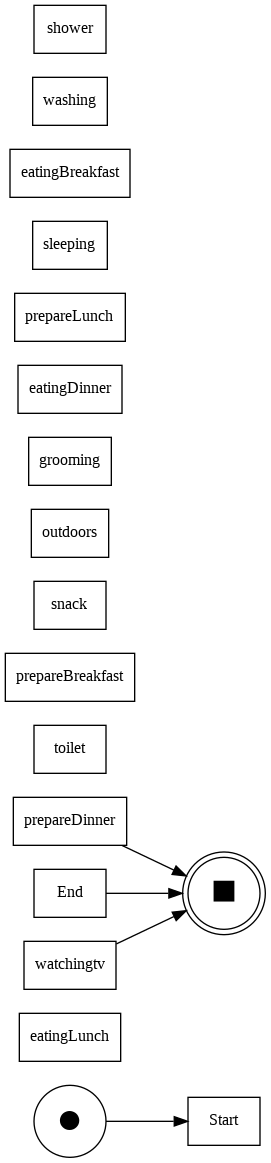

In [22]:
# Process Discovery with alpha miner for initial log
net, initial_marking, final_marking = alpha_miner.apply(log)

# show petri net
print('Alpha Miner PetriNet\n')
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

>> #### Evaluation of alpha miner in the initial log

In [23]:
# Perform token-based replay fitness evaluation
fitness = pm4py.fitness_token_based_replay(log, net, initial_marking, final_marking)

# Perform token-based replay precision evaluation
prec = pm4py.precision_token_based_replay(log, net, initial_marking, final_marking)

# Perform generalization evaluation
gen = generalization_evaluator.apply(log, net, initial_marking, final_marking)

# Perform simplicity evaluation
simp = simplicity_evaluator.apply(net)

# Print the evaluation results
print("Fitness:", fitness)
print("Precision:", prec)
print("Generalization:", gen)
print("Simplicity:", simp)

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.40872171012109104, 'log_fitness': 0.40336134453781514, 'percentage_of_fitting_traces': 0.0}
Precision: 0.032258064516129004
Generalization: 0.8601367407930312
Simplicity: 1.0


>> #### Conformance checking

In [24]:
# Replay fitness
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)
for trace in replayed_traces:
    print(trace)

# conformance checking - alignments
# aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)
# pretty_print_alignments(aligned_traces)

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

{'trace_is_fit': False, 'trace_fitness': 0.3703703703703704, 'activated_transitions': [(Start, 'Start'), (Start, 'Start'), (washing, 'washing'), (washing, 'washing'), (watchingtv, 'watchingtv'), (watchingtv, 'watchingtv'), (toilet, 'toilet'), (toilet, 'toilet'), (washing, 'washing'), (washing, 'washing'), (toilet, 'toilet'), (toilet, 'toilet'), (sleeping, 'sleeping'), (sleeping, 'sleeping'), (toilet, 'toilet'), (toilet, 'toilet'), (prepareBreakfast, 'prepareBreakfast'), (prepareBreakfast, 'prepareBreakfast'), (eatingBreakfast, 'eatingBreakfast'), (eatingBreakfast, 'eatingBreakfast'), (watchingtv, 'watchingtv'), (watchingtv, 'watchingtv'), (washing, 'washing'), (washing, 'washing'), (shower, 'shower'), (shower, 'shower'), (grooming, 'grooming'), (grooming, 'grooming'), (washing, 'washing'), (washing, 'washing'), (grooming, 'grooming'), (grooming, 'grooming'), (washing, 'washing'), (washing, 'washing'), (watchingtv, 'watchingtv'), (watchingtv, 'watchingtv'), (snack, 'snack'), (snack, 'sn

> ### Process Discovery with alpha miner for filtered log

Alpha Miner PetriNet



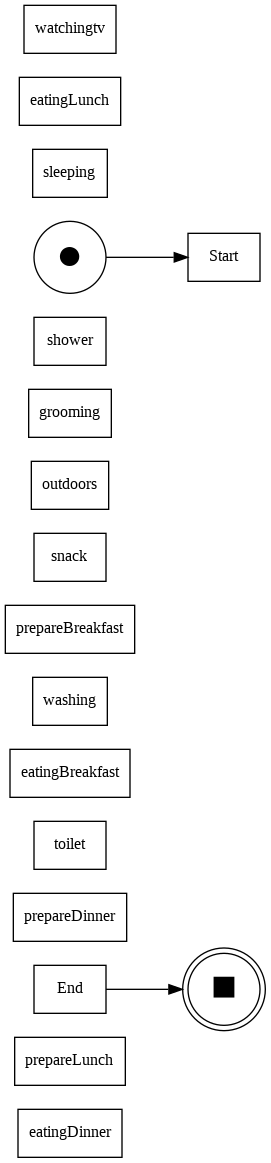

In [25]:
# Process Discovery with alpha miner for filtered log
net, initial_marking, final_marking = alpha_miner.apply(filtered_log)

# show petri net
print('Alpha Miner PetriNet\n')
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

>> #### Evaluation

In [26]:
# Perform token-based replay fitness evaluation
fitness = pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking)

# Perform token-based replay precision evaluation
prec = pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking)

# Perform generalization evaluation
gen = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)

# Perform simplicity evaluation
simp = simplicity_evaluator.apply(net)

# Print the evaluation results
print(fitness, " | ", prec, " | ", gen, " | ", simp)

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6666666666666664, 'log_fitness': 0.6666666666666667, 'percentage_of_fitting_traces': 0.0}  |  0.032258064516129004  |  0.8510005103170859  |  1.0


>> #### Conformance checking

In [27]:
# Replay fitness
replayed_traces = token_replay.apply(filtered_log, net, initial_marking, final_marking)
for trace in replayed_traces:
    print(trace)

# conformance checking - alignments
# aligned_traces = alignments.apply_log(filtered_log, net, initial_marking, final_marking)
# pretty_print_alignments(aligned_traces)

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

{'trace_is_fit': False, 'trace_fitness': 0.6666666666666667, 'activated_transitions': [(Start, 'Start'), (Start, 'Start'), (washing, 'washing'), (washing, 'washing'), (watchingtv, 'watchingtv'), (watchingtv, 'watchingtv'), (toilet, 'toilet'), (toilet, 'toilet'), (washing, 'washing'), (washing, 'washing'), (toilet, 'toilet'), (toilet, 'toilet'), (sleeping, 'sleeping'), (sleeping, 'sleeping'), (toilet, 'toilet'), (toilet, 'toilet'), (prepareBreakfast, 'prepareBreakfast'), (prepareBreakfast, 'prepareBreakfast'), (eatingBreakfast, 'eatingBreakfast'), (eatingBreakfast, 'eatingBreakfast'), (watchingtv, 'watchingtv'), (watchingtv, 'watchingtv'), (washing, 'washing'), (washing, 'washing'), (shower, 'shower'), (shower, 'shower'), (grooming, 'grooming'), (grooming, 'grooming'), (washing, 'washing'), (washing, 'washing'), (grooming, 'grooming'), (grooming, 'grooming'), (washing, 'washing'), (washing, 'washing'), (watchingtv, 'watchingtv'), (watchingtv, 'watchingtv'), (snack, 'snack'), (snack, 'sn

## **Heuristics Miner**

> ### Process Discovery with heuristics miner for initial log



Heuristics Miner PetriNet



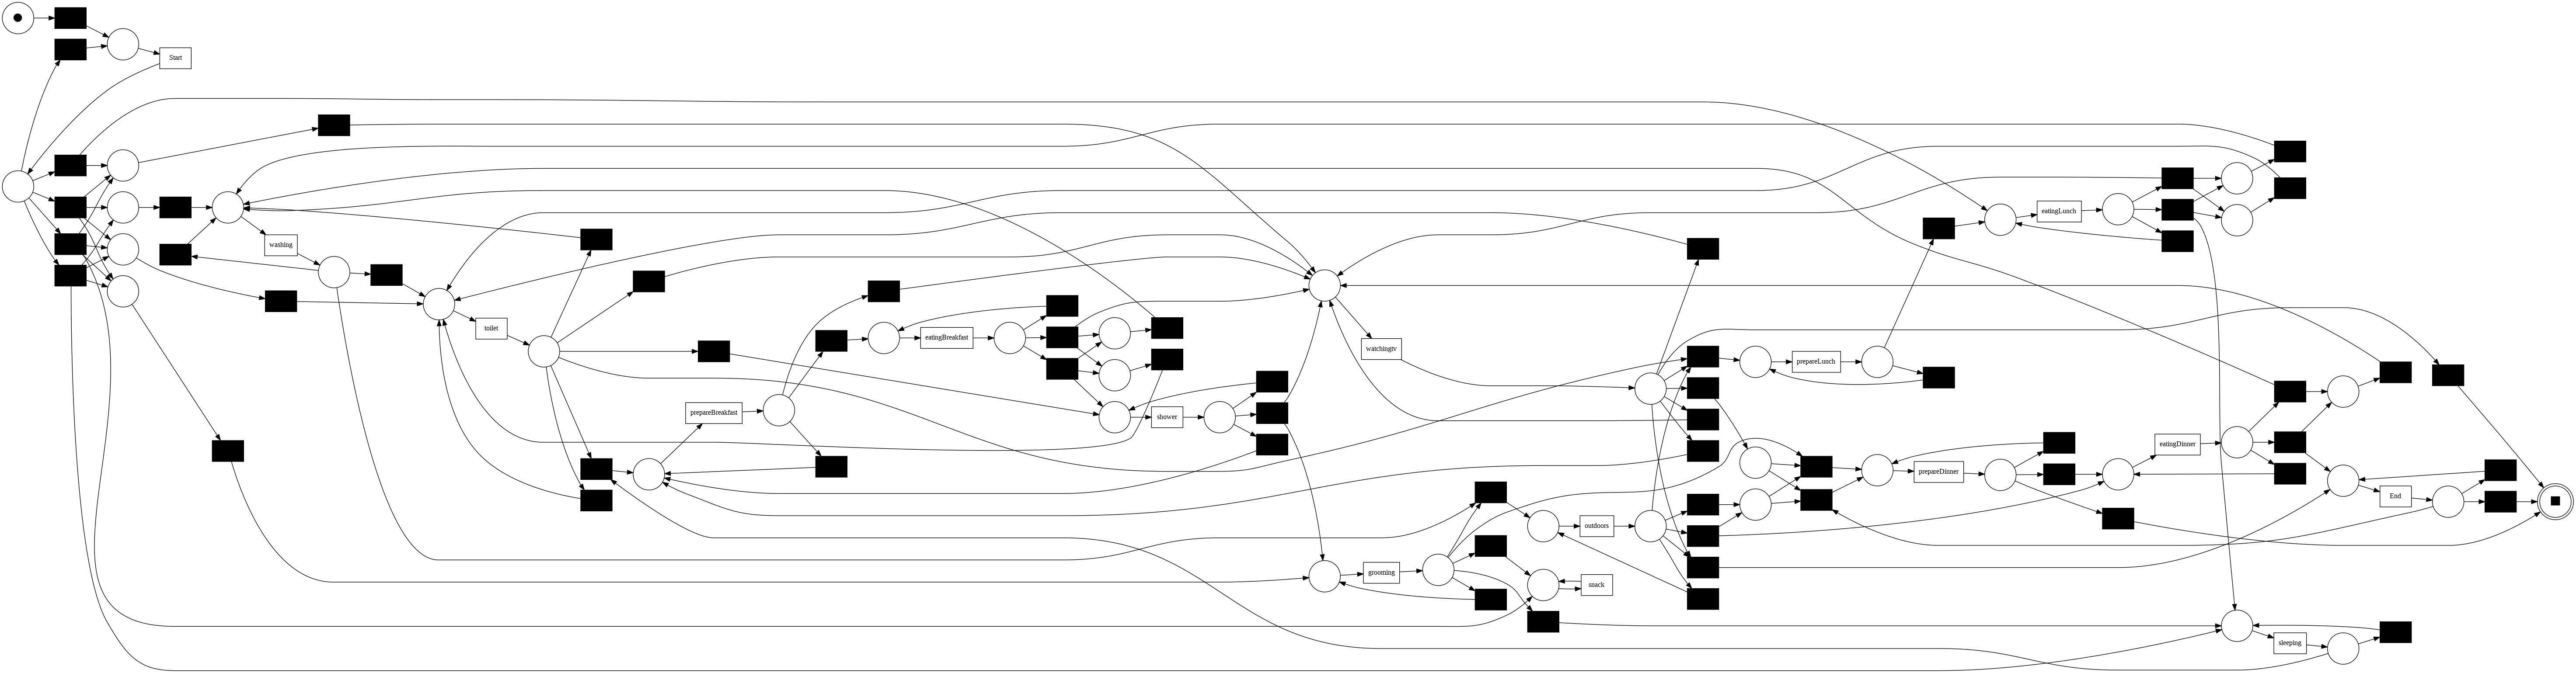

Heuristic Miner Graph



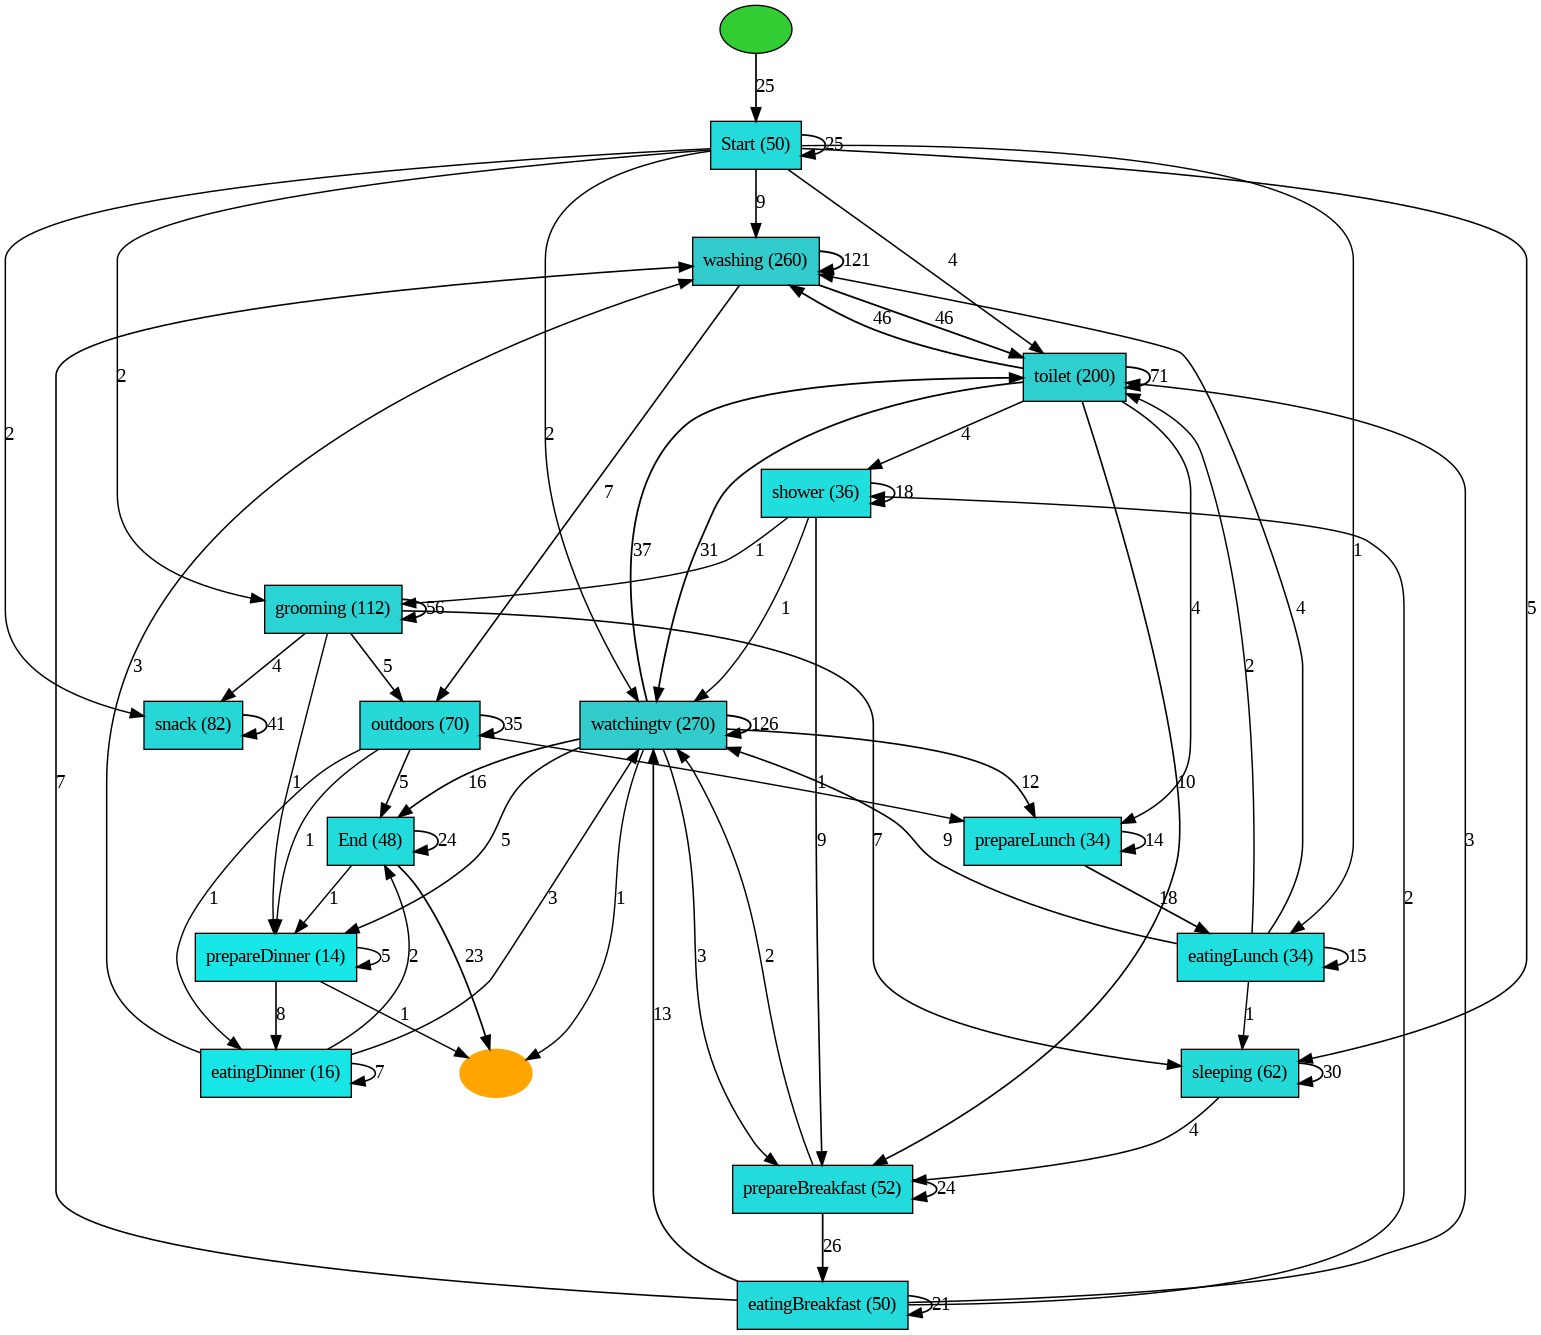

In [28]:
# Process Discovery with heuristics miner for initial log
net, initial_marking, final_marking = heuristics_miner.apply(log)

# show petri net
print('Heuristics Miner PetriNet\n')
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

# Process Discovery with heuristic miner - graph
heu_net = heuristics_miner.apply_heu(log)

# visualize graph
print('Heuristic Miner Graph\n')
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

>> #### Evaluation

In [29]:
# Perform token-based replay fitness evaluation
fitness = pm4py.fitness_token_based_replay(log, net, initial_marking, final_marking)

# Perform token-based replay precision evaluation
prec = pm4py.precision_token_based_replay(log, net, initial_marking, final_marking)

# Perform generalization evaluation
gen = generalization_evaluator.apply(log, net, initial_marking, final_marking)

# Perform simplicity evaluation
simp = simplicity_evaluator.apply(net)

# Print the evaluation results
print("Fitness:", fitness)
print("Precision:", prec)
print("Generalization:", gen)
print("Simplicity:", simp)

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9382771432828259, 'log_fitness': 0.9390944937878964, 'percentage_of_fitting_traces': 0.0}
Precision: 0.307909604519774
Generalization: 0.6368258629219157
Simplicity: 0.4859437751004016


>> #### Conformance Checking

In [30]:
# Replay fitness
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)
for trace in replayed_traces:
    print(trace)

# conformance checking - alignments
# aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)
# pretty_print_alignments(aligned_traces)

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

{'trace_is_fit': False, 'trace_fitness': 0.9480109322805952, 'activated_transitions': [(hid_2, None), (Start, 'Start'), (hid_58, None), (Start, 'Start'), (hid_60, None), (hid_3, None), (washing, 'washing'), (hid_66, None), (washing, 'washing'), (watchingtv, 'watchingtv'), (hid_72, None), (watchingtv, 'watchingtv'), (hid_65, None), (toilet, 'toilet'), (hid_77, None), (toilet, 'toilet'), (hid_78, None), (washing, 'washing'), (hid_66, None), (washing, 'washing'), (hid_65, None), (toilet, 'toilet'), (hid_77, None), (toilet, 'toilet'), (sleeping, 'sleeping'), (hid_86, None), (sleeping, 'sleeping'), (hid_77, None), (toilet, 'toilet'), (hid_77, None), (toilet, 'toilet'), (hid_48, None), (prepareBreakfast, 'prepareBreakfast'), (hid_105, None), (prepareBreakfast, 'prepareBreakfast'), (hid_104, None), (eatingBreakfast, 'eatingBreakfast'), (hid_115, None), (eatingBreakfast, 'eatingBreakfast'), (hid_117, None), (watchingtv, 'watchingtv'), (hid_72, None), (watchingtv, 'watchingtv'), (hid_4, None), 

> ### Process Discovery with heuristics miner for filtered log



Heuristics Miner PetriNet



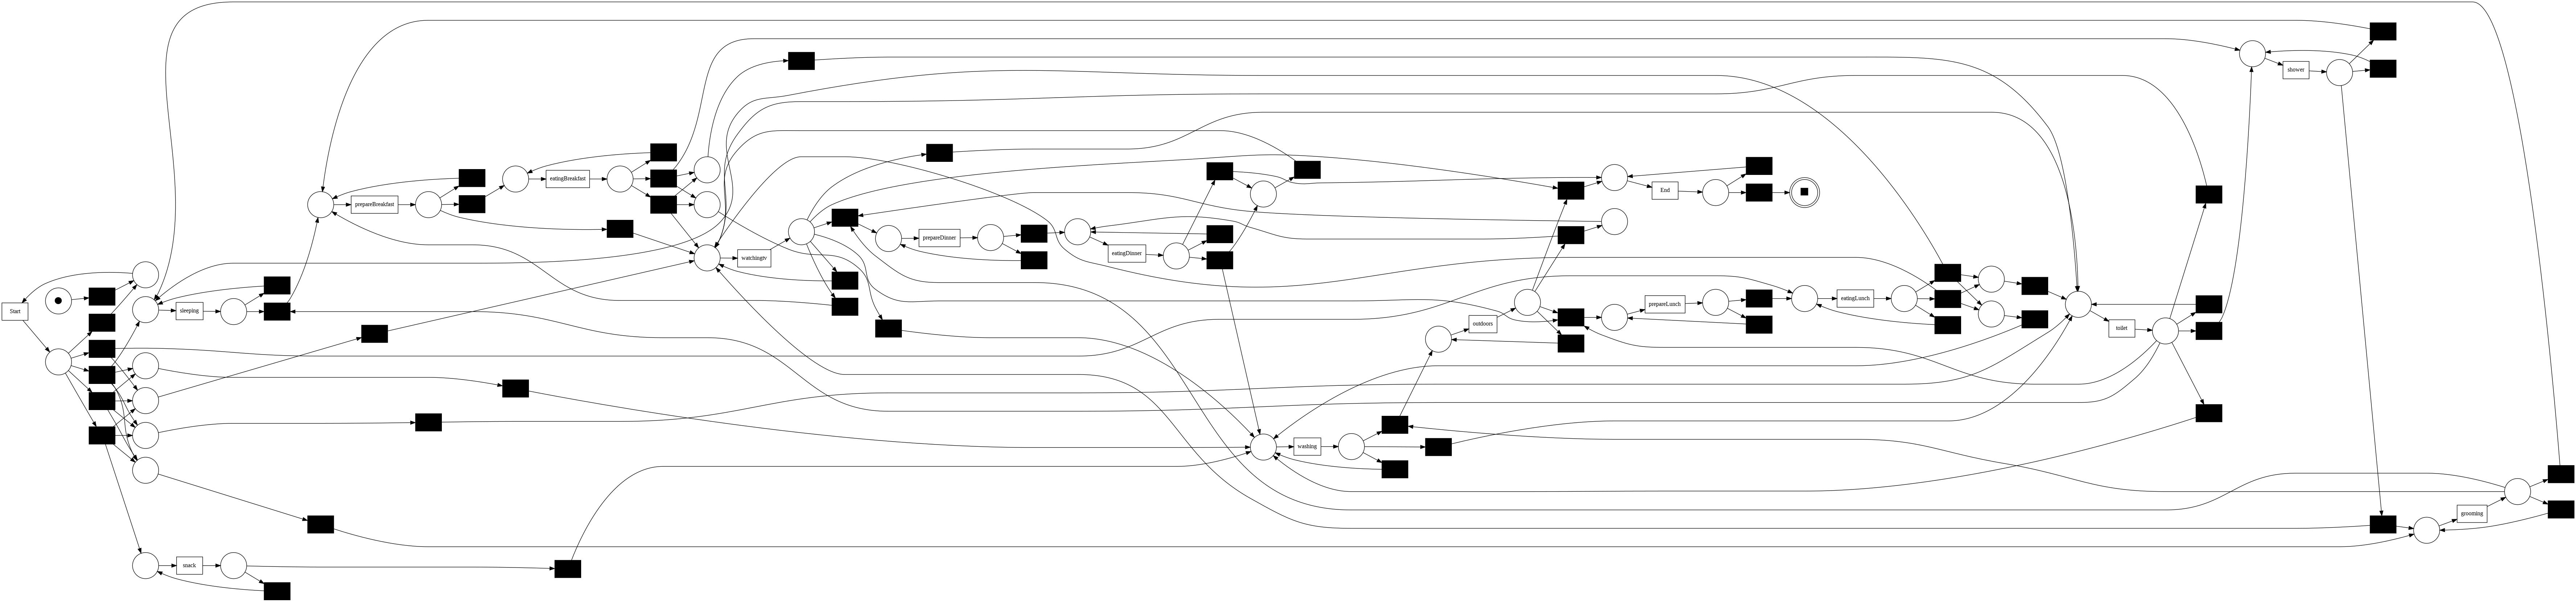

Heuristic Miner Graph



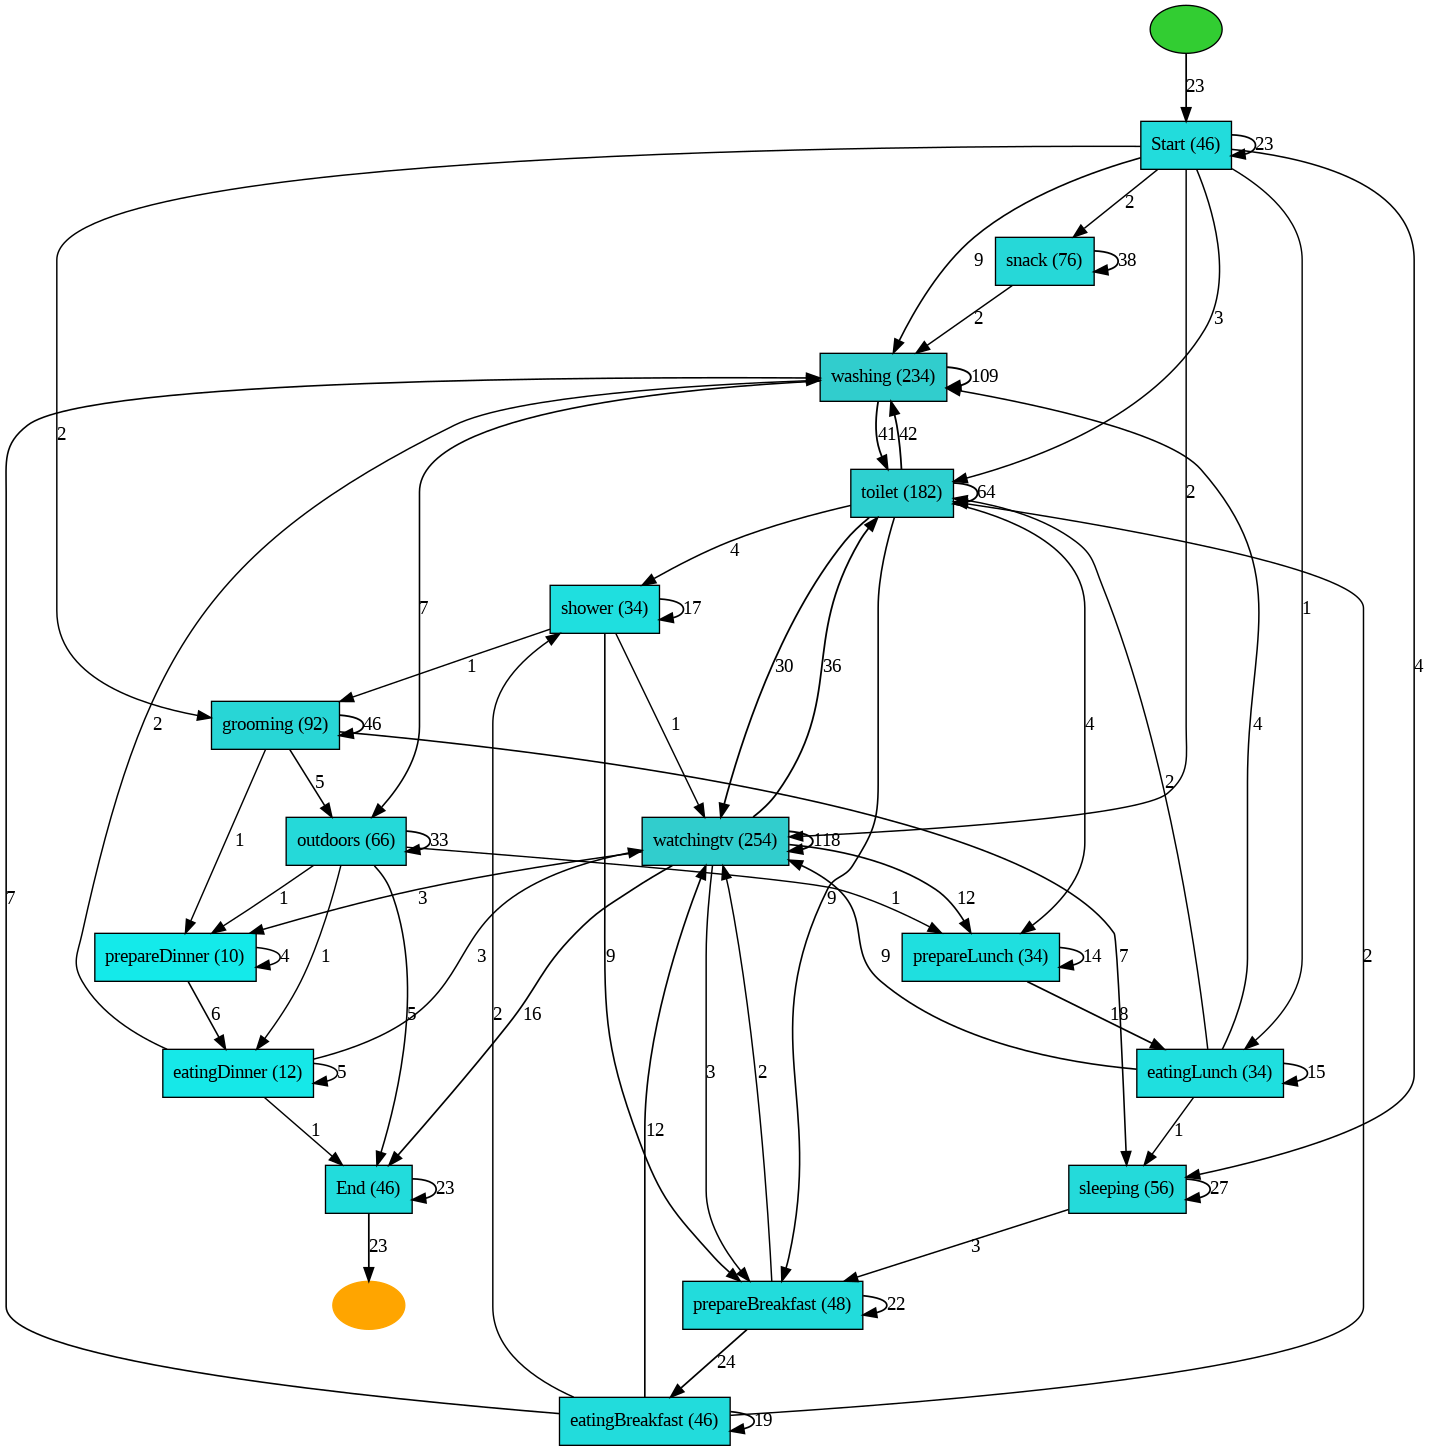

In [31]:
# Process Discovery with heuristics miner for filtered log
net, initial_marking, final_marking = heuristics_miner.apply(filtered_log)

# show petri net
print('Heuristics Miner PetriNet\n')
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

# Process Discovery with heuristic miner - graph
heu_net = heuristics_miner.apply_heu(filtered_log)

# visualize graph
print('Heuristic Miner Graph\n')
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

>> #### Evaluation

In [32]:
# Perform token-based replay fitness evaluation
fitness = pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking)

# Perform token-based replay precision evaluation
prec = pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking)

# Perform generalization evaluation
gen = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)

# Perform simplicity evaluation
simp = simplicity_evaluator.apply(net)

# Print the evaluation results
print(fitness, " | ", prec, " | ", gen, " | ", simp)

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9369441312704861, 'log_fitness': 0.9371859675594115, 'percentage_of_fitting_traces': 0.0}  |  0.27196885428253614  |  0.649855683454307  |  0.5021459227467812


>> #### Conformance Checking

In [33]:
# Replay fitness
replayed_traces = token_replay.apply(filtered_log, net, initial_marking, final_marking)
for trace in replayed_traces:
    print(trace)

# conformance checking - alignments
# aligned_traces = alignments.apply_log(filtered_log, net, initial_marking, final_marking)
# pretty_print_alignments(aligned_traces)

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

{'trace_is_fit': False, 'trace_fitness': 0.940467397405974, 'activated_transitions': [(hid_2, None), (Start, 'Start'), (hid_57, None), (Start, 'Start'), (hid_59, None), (hid_3, None), (washing, 'washing'), (hid_65, None), (washing, 'washing'), (watchingtv, 'watchingtv'), (hid_71, None), (watchingtv, 'watchingtv'), (hid_64, None), (toilet, 'toilet'), (hid_75, None), (toilet, 'toilet'), (hid_76, None), (washing, 'washing'), (hid_65, None), (washing, 'washing'), (hid_64, None), (toilet, 'toilet'), (hid_75, None), (toilet, 'toilet'), (sleeping, 'sleeping'), (hid_85, None), (sleeping, 'sleeping'), (hid_75, None), (toilet, 'toilet'), (hid_75, None), (toilet, 'toilet'), (hid_47, None), (prepareBreakfast, 'prepareBreakfast'), (hid_102, None), (prepareBreakfast, 'prepareBreakfast'), (hid_101, None), (eatingBreakfast, 'eatingBreakfast'), (hid_112, None), (eatingBreakfast, 'eatingBreakfast'), (hid_114, None), (watchingtv, 'watchingtv'), (hid_71, None), (watchingtv, 'watchingtv'), (hid_4, None), (

## **Inductive Miner**

> ### Process Discovery with inductive miner for initial log

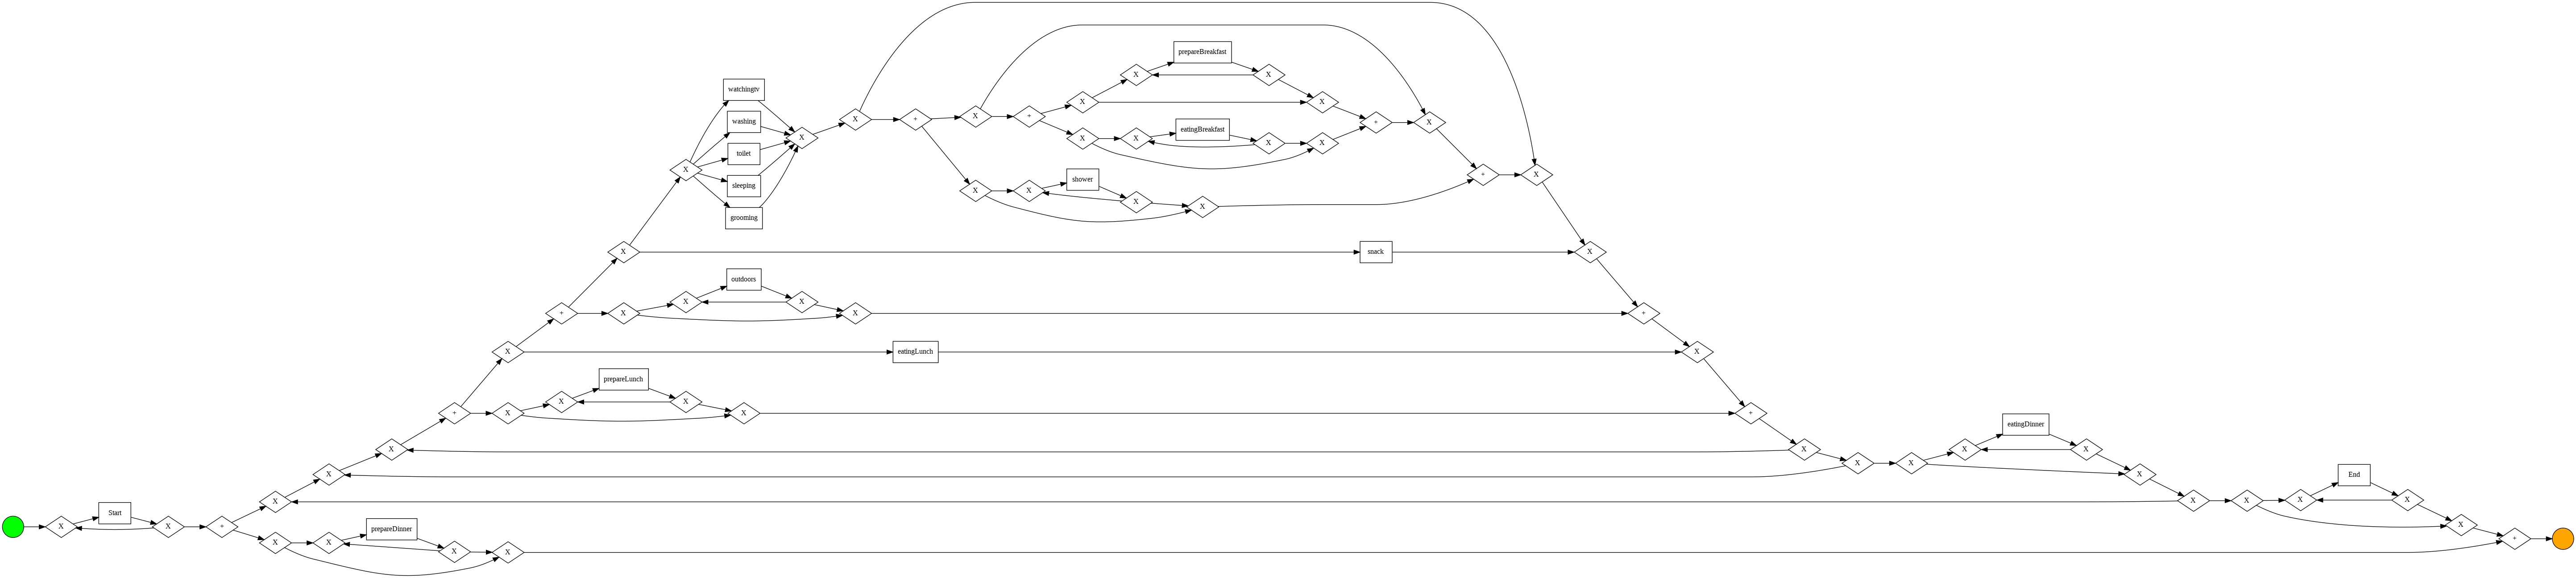

In [35]:
# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(log)

# Convert process tree to BPMN model
bpmn_model = pm4py.convert_to_bpmn(process_tree)

# Visualize BPMN model
pm4py.view_bpmn(bpmn_model)

# Convert process tree to Petri net
net, initial_marking, final_marking = process_tree_converter.apply(process_tree)

>> #### Evaluation

In [36]:
# Perform token-based replay fitness evaluation
fitness = pm4py.fitness_token_based_replay(log, net, initial_marking, final_marking)

# Perform token-based replay precision evaluation
prec = pm4py.precision_token_based_replay(log, net, initial_marking, final_marking)

# Perform generalization evaluation
gen = generalization_evaluator.apply(log, net, initial_marking, final_marking)

# Perform simplicity evaluation
simp = simplicity_evaluator.apply(net)

# Print the evaluation results
print("Fitness:", fitness)
print("Precision:", prec)
print("Generalization:", gen)
print("Simplicity:", simp)

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision: 0.08486152191449314
Generalization: 0.7776818167969985
Simplicity: 0.6483516483516484


>> #### Conformance Checking

In [37]:
# Replay fitness
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)
for trace in replayed_traces:
    print(trace)

# conformance checking - alignments
# aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)
# pretty_print_alignments(aligned_traces)

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(tau_1, None), (059c752b-8116-42ce-9163-69988f6c1f29, 'Start'), (skip_5, None), (059c752b-8116-42ce-9163-69988f6c1f29, 'Start'), (skip_6, None), (init_loop_16, None), (init_loop_18, None), (tauSplit_20, None), (tauSplit_27, None), (8e7fa83d-6867-4eb2-92b7-bd6df962e31f, 'washing'), (skip_22, None), (skip_29, None), (skip_34, None), (tauJoin_28, None), (tauJoin_21, None), (skip_55, None), (tauSplit_20, None), (tauSplit_27, None), (8e7fa83d-6867-4eb2-92b7-bd6df962e31f, 'washing'), (skip_22, None), (skip_29, None), (skip_34, None), (tauJoin_28, None), (tauJoin_21, None), (skip_55, None), (tauSplit_20, None), (tauSplit_27, None), (e23a7b81-6386-4a25-ab3a-c560c8a7b54a, 'watchingtv'), (skip_22, None), (skip_29, None), (skip_34, None), (tauJoin_28, None), (tauJoin_21, None), (skip_55, None), (tauSplit_20, None), (tauSplit_27, None), (e23a7b81-6386-4a25-ab3a-c560c8a7b54a, 'watchingtv'), (skip_22, None), (skip_29, None), (ski

> ### Process Discovery with inductive miner for filtered log

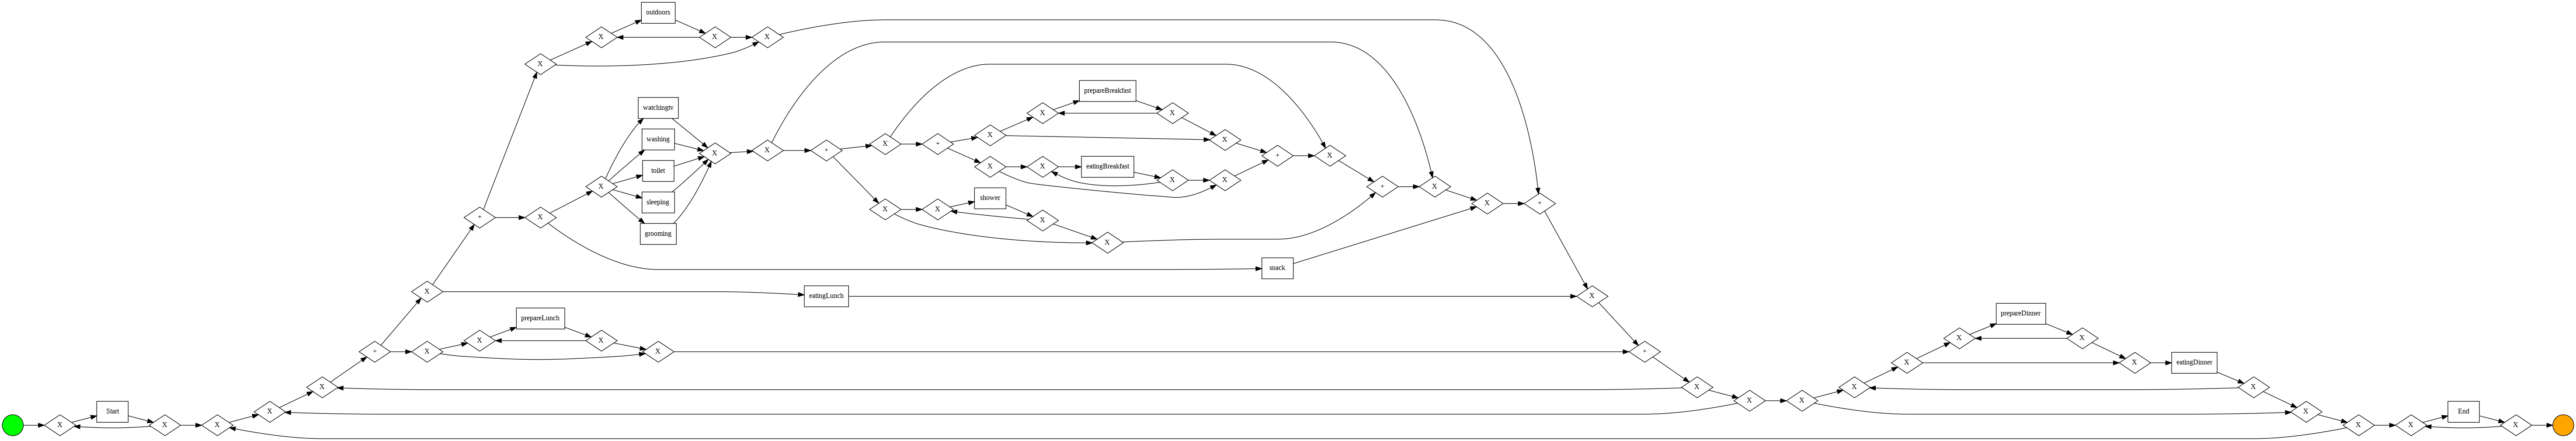

In [38]:
# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(filtered_log)

# Convert process tree to BPMN model
bpmn_model = pm4py.convert_to_bpmn(process_tree)

# Visualize BPMN model
pm4py.view_bpmn(bpmn_model)

# Convert process tree to Petri net
net, initial_marking, final_marking = process_tree_converter.apply(process_tree)

>> #### Evaluation

In [39]:
# Perform token-based replay fitness evaluation
fitness = pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking)

# Perform token-based replay precision evaluation
prec = pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking)

# Perform generalization evaluation
gen = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)

# Perform simplicity evaluation
simp = simplicity_evaluator.apply(net)

# Print the evaluation results
print(fitness, " | ", prec, " | ", gen, " | ", simp)

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}  |  0.08739998778476765  |  0.7744083730199272  |  0.6511627906976745


>> #### Conformance Checking

In [40]:
# Replay fitness
replayed_traces = token_replay.apply(filtered_log, net, initial_marking, final_marking)
for trace in replayed_traces:
    print(trace)

# conformance checking - alignments
# aligned_traces = alignments.apply_log(filtered_log, net, initial_marking, final_marking)
# pretty_print_alignments(aligned_traces)

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(tau_1, None), (57205b35-6ea2-4107-b883-81d59792ad81, 'Start'), (skip_5, None), (57205b35-6ea2-4107-b883-81d59792ad81, 'Start'), (skip_6, None), (init_loop_9, None), (init_loop_11, None), (tauSplit_13, None), (tauSplit_20, None), (c0ddcb0b-85a8-4779-8ce1-5865fa173364, 'washing'), (skip_15, None), (skip_22, None), (skip_27, None), (tauJoin_21, None), (tauJoin_14, None), (skip_48, None), (tauSplit_13, None), (tauSplit_20, None), (c0ddcb0b-85a8-4779-8ce1-5865fa173364, 'washing'), (skip_15, None), (skip_22, None), (skip_27, None), (tauJoin_21, None), (tauJoin_14, None), (skip_48, None), (tauSplit_13, None), (tauSplit_20, None), (f9ea4efe-4356-49d4-8f62-60c4cf1c6937, 'watchingtv'), (skip_15, None), (skip_22, None), (skip_27, None), (tauJoin_21, None), (tauJoin_14, None), (skip_48, None), (tauSplit_13, None), (tauSplit_20, None), (f9ea4efe-4356-49d4-8f62-60c4cf1c6937, 'watchingtv'), (skip_15, None), (skip_22, None), (skip